In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pyproj
pd.set_option("display.max_rows", 500)
import pdb

from pycontrails import Flight, Fleet, MetDataset
from pycontrails.core import datalib, models
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.physics import geo, thermo, units, constants
from pycontrails.models.ps_model import PSFlight 
from pycontrails.models.emissions import Emissions
from pycontrails.ext.flight_gen import FlightGen
from pycontrails.models.boxm import Boxm
from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core.met_var import (
    AirTemperature,
    RelativeHumidity,
    SpecificHumidity,
    EastwardWind,
    NorthwardWind,
    VerticalVelocity,
)

In [2]:
# meteorological parameters
met_params = {
    "air_temperature": 240.0,  # K
    "specific_humidity": 0.001,  # 1
    "relative_humidity": 0.5,  # 1
    "eastward_wind": 0.0,  # m/s
    "northward_wind": 0.0,  # m/s
    "lagrangian_tendency_of_air_pressure": 0.0,  # m/s
}

In [3]:
# flight trajectory parameters
fl_params = {
    "t0_fl": pd.to_datetime("2022-03-02 14:00:00"),  # flight start time
    "rt_fl": pd.Timedelta(minutes=30),  # flight run time
    "ts_fl": pd.Timedelta(minutes=2),  # flight time step
    "ac_type": "A320",  # aircraft type
    "fl0_speed": 100.0,  # m/s
    "fl0_heading": 45.0,  # deg
    "fl0_coords0": (-0.8, -0.8, 11500),  # lat, lon, alt [deg, deg, m]
    "sep_dist": (5000, 2000, 0),  # dx, dy, dz [m]
    "n_ac": 2,  # number of aircraft
}

In [4]:
# plume dispersion parameters
plume_params = {
    "dt_integration": pd.Timedelta(minutes=5), # integration time step
    "max_age": pd.Timedelta(hours=1), # maximum age of the plume
    "depth": 50.0,  # initial plume depth, [m]
    "width": 40.0,  # initial plume width, [m]
    "shear": 0.005 # wind shear [1/s]
}

In [5]:
# chemistry sim parameters
chem_params = {
    "t0_chem": pd.to_datetime("2022-03-01 21:00:00"),  # chemistry start time
    "rt_chem": pd.Timedelta(days=1),  # chemistry runtime
    "ts_chem": pd.Timedelta(minutes=5),  # chemistry time step
    "lat_bounds": (-1.0, 1.0),  # lat bounds [deg]
    "lon_bounds": (-1.0, 1.0),  # lon bounds [deg]
    "alt_bounds": (11000, 12500),  # alt bounds [m]
    "hres_chem": 0.1,  # horizontal resolution [deg]
    "vres_chem": 100,  # vertical resolution [m]
}

In [6]:
# create lists for lats, lons, alts, and times based on chem params
lats = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1], chem_params["hres_chem"]
)

lons = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1], chem_params["hres_chem"]
)

alts = np.arange(
    chem_params["alt_bounds"][0], chem_params["alt_bounds"][1], chem_params["vres_chem"]
)

times = pd.date_range(
    start=chem_params["t0_chem"],
    end=chem_params["t0_chem"] + chem_params["rt_chem"],
    freq=chem_params["ts_chem"],
)

In [7]:
# generate artifical met dataset (boxm currently only supports zero-wind scenarios)
data_vars = {
    param: (
        ["longitude", "latitude", "level", "time"],
        da.full(
            (len(lons), len(lats), len(alts), len(times)),
            value,
            chunks=(len(lons), len(lats), len(alts), 100),
        ),
    )
    for param, value in met_params.items()
}

met = xr.Dataset(
    data_vars, coords={"longitude": lons, "latitude": lats, "level": units.m_to_pl(alts), "time": times}
)

met = MetDataset(met)

met

MetDataset with data:

<xarray.Dataset> Size: 83MB
Dimensions:                              (longitude: 20, latitude: 20,
                                          level: 15, time: 289)
Coordinates:
  * longitude                            (longitude) float64 160B -1.0 ... 0.9
  * latitude                             (latitude) float64 160B -1.0 ... 0.9
  * level                                (level) float64 120B 181.5 ... 226.3
  * time                                 (time) datetime64[ns] 2kB 2022-03-01...
    air_pressure                         (level) float64 120B 1.815e+04 ... 2...
    altitude                             (level) float64 120B 1.24e+04 ... 1....
Data variables:
    air_temperature                      (longitude, latitude, level, time) float64 14MB dask.array<chunksize=(20, 20, 15, 100), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float64 14MB dask.array<chunksize=(20, 20, 15, 100), meta=np.ndarray>
    relative_humidity                    (longitude, latitude, level, time) float64 14MB dask.array<chunksize=(20, 20, 15, 100), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float64 14MB dask.array<chunksize=(20, 20, 15, 100), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float64 14MB dask.array<chunksize=(20, 20, 15, 100), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float64 14MB dask.array<chunksize=(20, 20, 15, 100), meta=np.ndarray>

In [8]:
# generate flight trajectories
fl_gen = FlightGen(met, fl_params, plume_params, chem_params)

In [9]:
flights = fl_gen.traj_gen()

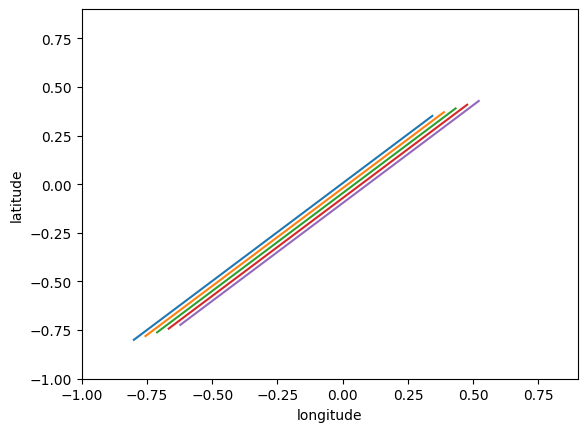

In [10]:
# visualise the fleet
ax = plt.axes()
ax.set_xlim([lons[0], lons[-1]])
ax.set_ylim([lats[0], lats[-1]])
for fl in flights:
    fl.plot(ax=ax)

In [11]:
# estimate fuel burn and emissions using ps_model and emissions model
flights = fl_gen.calc_fb_emissions()


In [12]:
# simulate plume dispersion/advection using dry advection model
pl_df = fl_gen.sim_plumes()

pl_df


,flight_id,waypoint,fuel_flow,true_airspeed,co2_m,h2o_m,so2_m,nox_m,co_m,hcho_m,...,nvpm_m,time,longitude,latitude,level,width,heading,sin_a,cos_a,altitude
0,0.0,0,0.681392,100.226419,2.148335e-07,8.362190e-08,5.710764e-11,7.268712e-10,3.811278e-11,4.461984e-13,...,4.874545e-12,2022-03-02 14:05:00,-0.800000,-0.800000,209.158358,95.096588,45.004186,0.707158,0.707055,11500.0
36,0.0,1,0.681392,100.226862,2.148327e-07,8.362157e-08,5.710741e-11,7.268686e-10,3.811263e-11,4.461967e-13,...,4.874526e-12,2022-03-02 14:05:00,-0.761888,-0.761629,209.158358,78.300708,45.004186,0.707158,0.707055,11500.0
72,0.0,2,0.681393,100.227283,2.148318e-07,8.362125e-08,5.710720e-11,7.268661e-10,3.811249e-11,4.461950e-13,...,4.874507e-12,2022-03-02 14:05:00,-0.723776,-0.723258,209.158358,63.385850,45.003941,0.707155,0.707058,11500.0
108,0.0,3,0.681393,100.227682,2.148311e-07,8.362095e-08,5.710699e-11,7.268637e-10,3.811235e-11,4.461934e-13,...,4.874490e-12,2022-03-02 14:05:00,-0.685664,-0.684887,209.158358,51.150514,45.003708,0.707153,0.707061,11500.0
144,0.0,4,0.681393,100.228058,2.148303e-07,8.362067e-08,5.710680e-11,7.268615e-10,3.811222e-11,4.461919e-13,...,4.874473e-12,2022-03-02 14:05:00,-0.647552,-0.646515,209.158358,42.889939,45.003488,0.707150,0.707064,11500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,0.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2022-03-02 17:30:00,0.343314,0.351157,209.158358,9598.388078,NaN,NaN,NaN,11500.0
2231,1.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2022-03-02 17:30:00,0.387782,0.370342,209.158358,9598.388078,NaN,NaN,NaN,11500.0
3347,2.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2022-03-02 17:30:00,0.432250,0.389527,209.158358,9598.388078,NaN,NaN,NaN,11500.0
4463,3.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2022-03-02 17:30:00,0.476718,0.408711,209.158358,9598.388078,NaN,NaN,NaN,11500.0


In [13]:
# convert plume dataframe to EMI geospatial xarray dataset 
emi = fl_gen.plume_to_grid()

Processing time:  2022-03-02 14:05:00


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:10:00


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:15:00


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:20:00


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:25:00


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:30:00


  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:35:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:40:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:45:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:50:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:55:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:00:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:05:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:10:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:15:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:20:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:25:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:30:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:35:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:40:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:45:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:50:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:55:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:00:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:05:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:10:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:15:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:20:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:25:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:30:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:35:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:40:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:45:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:50:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:55:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 17:00:00


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Processing time:  2022-03-02 17:05:00


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Processing time:  2022-03-02 17:10:00


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing time:  2022-03-02 17:15:00


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Processing time:  2022-03-02 17:20:00


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Processing time:  2022-03-02 17:25:00


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Processing time:  2022-03-02 17:30:00


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 42, longitude: 21, latitude: 21)
Coordinates:
  * longitude  (longitude) float64 168B -1.0 -0.9 -0.8 -0.7 ... 0.7 0.8 0.9 1.0
  * latitude   (latitude) float64 168B -1.0 -0.9 -0.8 -0.7 ... 0.7 0.8 0.9 1.0
  * time       (time) datetime64[ns] 336B 2022-03-02T14:05:00 ... 2022-03-02T...
Data variables:
    nox_m      (time, longitude, latitude) float64 148kB 0.0 0.0 0.0 ... 0.0 0.0
    co_m       (time, longitude, latitude) float64 148kB 0.0 0.0 0.0 ... 0.0 0.0
    hcho_m     (time, longitude, latitude) float64 148kB 0.0 0.0 0.0 ... 0.0 0.0
    ch3cho_m   (time, longitude, latitude) float64 148kB 0.0 0.0 0.0 ... 0.0 0.0
    c2h4_m     (time, longitude, latitude) float64 148kB 0.0 0.0 0.0 ... 0.0 0.0
    c3h6_m     (time, longitude, latitude) float64 148kB 0.0 0.0 0.0 ... 0.0 0.0
    c2h2_m     (time, longitude, latitude) float64 148kB 0.0 0.0 0.0 ... 0.0 0.0
    benzene_m  (time, longitude, latitude) float64 148kB 0.0 0.0 0.0 ... 0.0 0.0

In [19]:
# run boxm simulation and generate chemistry dataset
chem = Boxm()

NameError: name 'Boxm' is not defined